<a href="https://colab.research.google.com/github/Jyoti-S-Shukla/Machine-learning-models/blob/main/clustering_plots_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


Automatically created module for IPython interactive environment


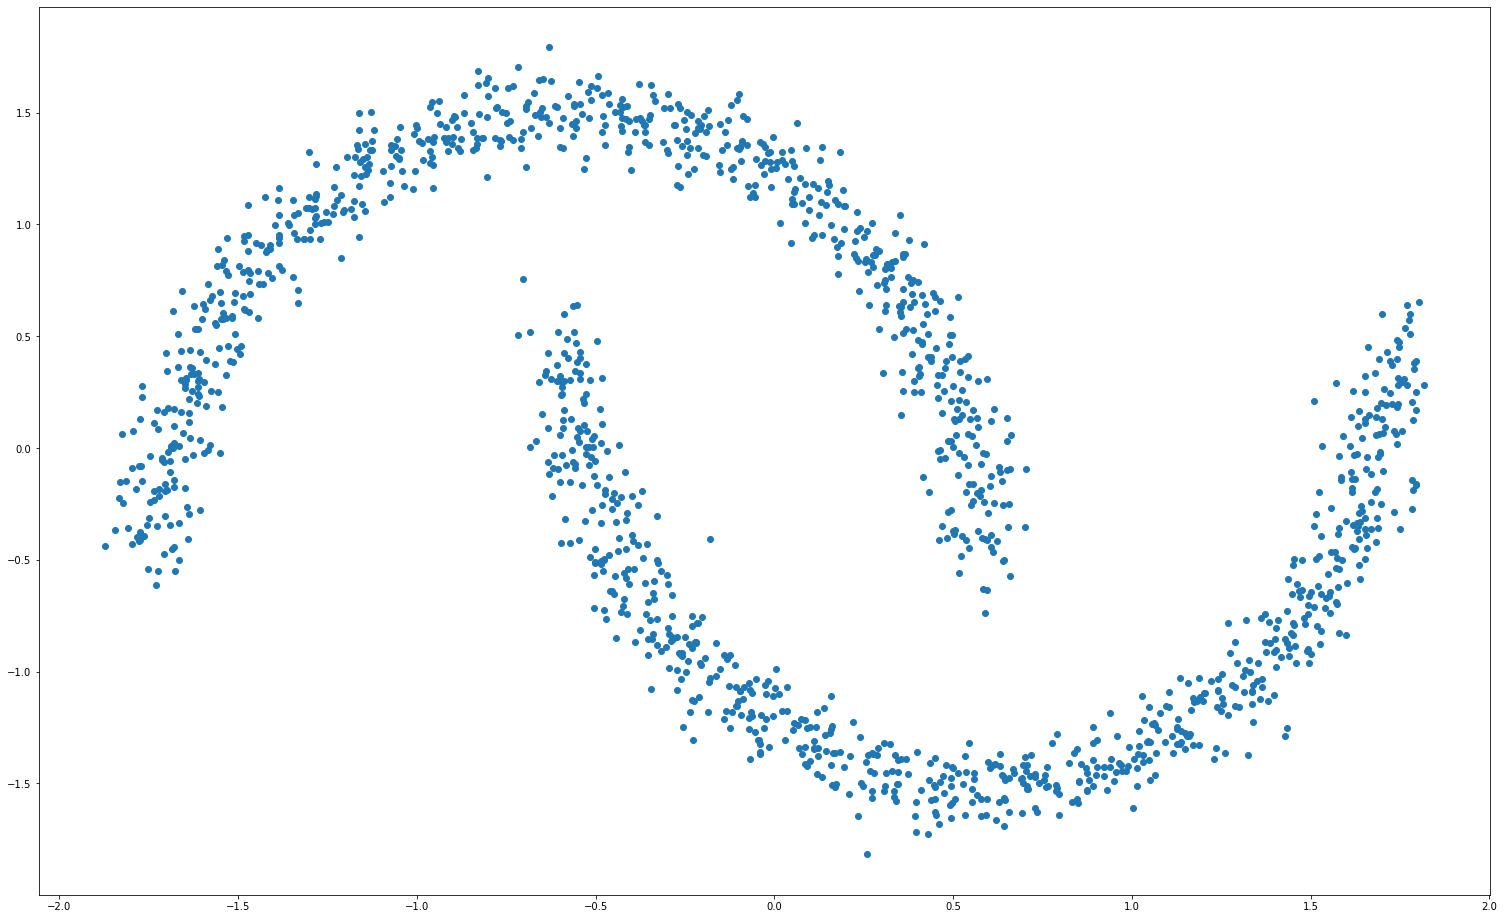

In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

"""
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    plt.scatter(X[:,0],X[:,1],marker='o')
    plt.show()"""
dataset,algo_params = (datasets[1])  
#print(dataset)
X,y = (dataset)
X = StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='o')
plt.show()


Number of clusters formed are: 3
Count: {0: 4, 1: 747, 2: 750}
Number of outliers found:  4


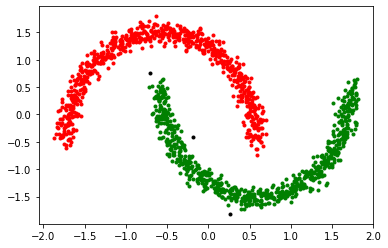

In [ ]:
## Write your code here
#dataset = df.astype(float).values.tolist()
from itertools import islice
from itertools import cycle
import queue
from sklearn.preprocessing import StandardScaler


class CustomDBSCAN:
      def __init__(self):
        self.core = -1
        self.border = -2
     # Find all neighbour points at epsilon distance
      def neighbour_points(self, data, pointId, epsilon):
        points = []
        for i in range(len(data)):
          # Euclidian distance
          if np.linalg.norm([a_i - b_i for a_i, b_i in zip(data[i], data[pointId])]) <= epsilon:
            points.append(i)
        return points
      # Fit the data into the DBSCAN model
      def fit(self, data, Eps, MinPt):
        # initialize all points as outliers
        point_label = [0] * len(data)
        point_count = []
        # initilize list for core/border points
        core = []
        border = []
        # Find the neighbours of each individual point
        for i in range(len(data)):
          point_count.append(self.neighbour_points(data, i, Eps))
    # Find all the core points, border points and outliers
        for i in range(len(point_count)):
          if (len(point_count[i]) >= MinPt):
            point_label[i] = self.core
            core.append(i)
          else:
            border.append(i)
        for i in border:
          for j in point_count[i]:
            if j in core:
              point_label[i] = self.border
              break

      # Assign points to a cluster
        cluster = 1
      # Here we use a queue to find all the neighbourhood points of a core point and find the
    # indirectly reachable points.
    # We are essentially performing Breadth First search of all points which are within
    # epsilon distance from each other
        for i in range(len(point_label)):
            q = queue.Queue()
            if (point_label[i] == self.core):
              point_label[i] = cluster
              for x in point_count[i]:
                if(point_label[x] == self.core):
                  q.put(x)
                  point_label[x] = cluster
                elif(point_label[x] == self.border):
                  point_label[x] = cluster
              while not q.empty():
                neighbors = point_count[q.get()]
                for y in neighbors:
                    if (point_label[y] == self.core):
                        point_label[y] = cluster
                        q.put(y)
                    if (point_label[y] == self.border):
                        point_label[y] = cluster
              cluster += 1  # Move on to the next cluster
        print("Number of clusters formed are:", cluster)
        return point_label, cluster
      def visualize(self, data, cluster, numberOfClusters):
        N = len(data)
        # Define colors, ideally better to have around 7-10 colors defined
        colors = np.array(list(islice(cycle(['pink', 'green','red','brown','yellow','grey','blue','violet']), 3)))
        count ={}
        o =0
        for i in range(numberOfClusters):
          if (i == 0):
            # Plot all outliers point as black
            color = '#000000'
            count[i]=count.get(i,0)+1
          else:
            color = colors[i % len(colors)]

          x, y = [], []
          for j in range(N):
            if cluster[j] == i:
                count[i]=count.get(i,0)+1
                x.append(data[j, 0])
                y.append(data[j, 1])
          
          plt.scatter(x, y, c=color, alpha=1, marker='.')
        print("Count:",count)
        print("Number of outliers found: ",count[0])
      plt.show()
      

custom_DBSCAN = CustomDBSCAN()
point_labels, clusters = custom_DBSCAN.fit(X, 0.15, 3)
#print(point_labels, clusters)
custom_DBSCAN.visualize(X, point_labels, clusters)


[0.38162354968381373, 0.3091882310336665, 0.3091882192825197]

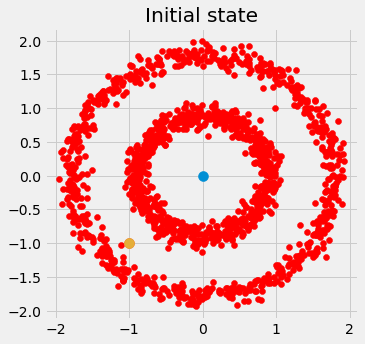

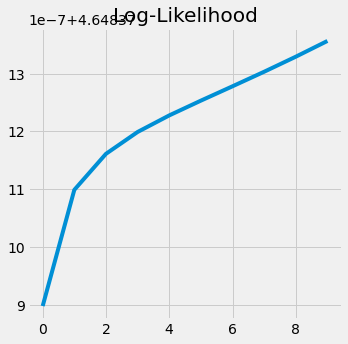

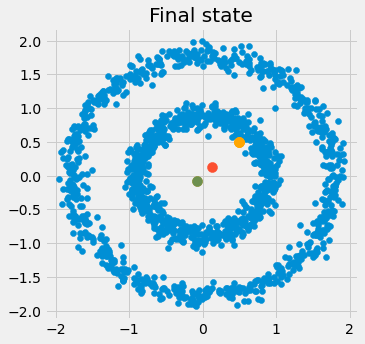

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal

Y_target =y
# 0. Create dataset
#X,y = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=3)

# Stratch dataset to get ellipsoid data
X = X
 

class GMM:

    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    

    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(self.X[0]))
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
           
                    
        """ 1. Set the initial mu, covariance and pi values"""
        self.mu = np.random.randint(min(self.X[:,0]),max(self.X[:,0]),size=(self.number_of_sources,len(self.X[0]))) # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
        self.cov = np.zeros((self.number_of_sources,len(X[0]),len(X[0]))) # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim],5)


        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                             # if we have converged
            
        """Plot the initial state"""    
        fig = plt.figure(figsize=(5,5))
        ax0 = fig.add_subplot(111)
        ax0.scatter(self.X[:,0],self.X[:,1], c= 'red')
        ax0.set_title('Initial state')
        for m,c in zip(self.mu,self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m,cov=c)
            #ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax0.scatter(m[0],m[1],cmap='rainbow',zorder=10,s=100)
        
        for i in range(self.iterations):               

            """E Step"""
            r_ic = np.zeros((len(self.X),len(self.cov)))

            for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
                co+=self.reg_cov
                mn = multivariate_normal(mean=m,cov=co)
                r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)

          

            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:,c],axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
                self.mu.append(mu_c)

                # Calculate the covariance matrix per source based on the new mean
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
                # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
                self.pi.append(m_c/np.sum(r_ic))           
            
            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))

        fig2 = plt.figure(figsize=(5,5))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        #plt.show()
    
    """Predict the membership of an unseen, new datapoint"""
    def predict(self,Y):
        # PLot the point onto the fittet gaussians
        fig3 = plt.figure(figsize=(5,5))
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            multi_normal = multivariate_normal(mean=m,cov=c)
            #ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],cmap='rainbow',zorder=10,s=100)
            ax2.set_title('Final state')
            for y in Y:
                ax2.scatter(y[0],y[1],c='orange',zorder=10,s=100)
        prediction = []        
        for m,c in zip(self.mu,self.cov):  
            #print(c)
            prediction.append(multivariate_normal(mean=m,cov=c).pdf(Y)/np.sum([multivariate_normal(mean=mean,cov=cov).pdf(Y) for mean,cov in zip(self.mu,self.cov)]))
        #plt.show()
        return prediction
         

 
GMM=GMM(X,3,10)
GMM.run()
GMM.predict([[0.5,0.5]])

Number of Iteration : 0


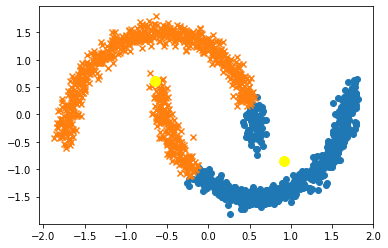

Number of Iteration : 1


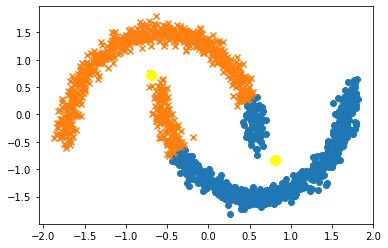

Number of Iteration : 2


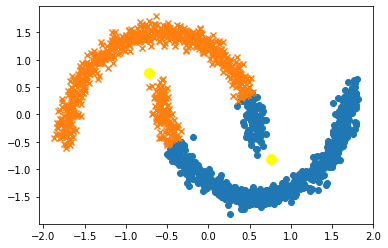

Number of Iteration : 3


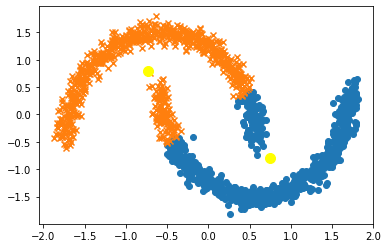

Number of Iteration : 4


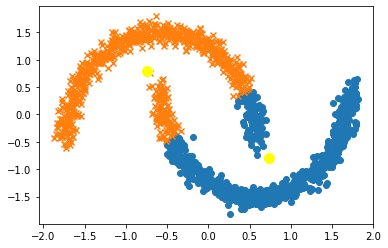

Number of Iteration : 5


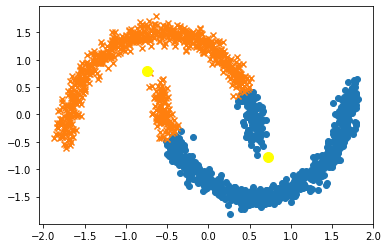

Number of Iteration : 6


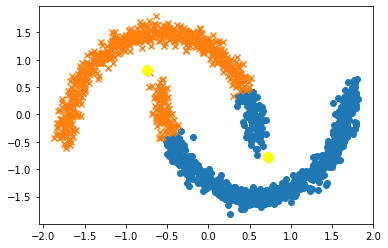

Number of Iteration : 7


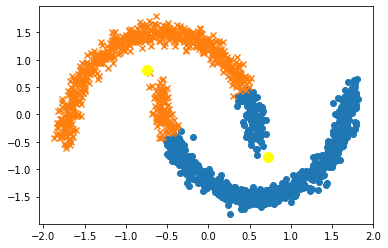

Number of Iteration : 8


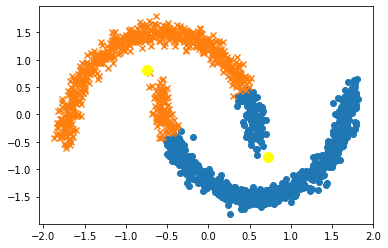

Number of Iteration : 9


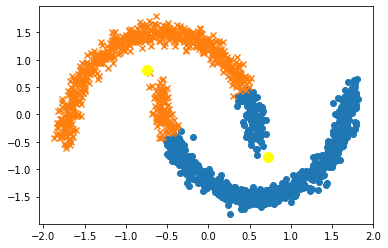

In [ ]:
sample = X
K=2 # number of clusters
n_iter = 10
m = sample.shape[0] 
n= sample.shape[1]# no. of feature ,here 2
Centroids=np.array([]).reshape(n,0) 
Output={}
for i in range(K):
    rand=np.random.randint(0,m-1)
    Centroids=np.c_[Centroids,sample[rand]]
for i in range(n_iter):
      print("Number of Iteration :",i)
     #step 2.a
      EuclidianDistance=np.array([]).reshape(m,0)
      for k in range(K):
          tempDist=np.sum((sample-Centroids[:,k])**2,axis=1)
          EuclidianDistance=np.c_[EuclidianDistance,tempDist]
      C=np.argmin(EuclidianDistance,axis=1)+1
     #step 2.b
      Y={}
      for k in range(K):
          Y[k+1]=np.array([]).reshape(2,0)
      for i in range(m):
          Y[C[i]]=np.c_[Y[C[i]],sample[i]]
     
      for k in range(K):
          Y[k+1]=Y[k+1].T
    
      for k in range(K):
          Centroids[:,k]=np.mean(Y[k+1],axis=0)
      Output=Y
      markers =['o','x','*','+',(5,1),'.']
      #WCSS_array=np.array([])
      #wcss =0
      for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],marker=markers[k])
        #wcss+=np.sum((Output[k+1]-Centroids[:,k])**2)
        #WCSS_array=np.append(WCSS_array,wcss)
      #WCSS_array=np.append(WCSS_array,wcss)
      plt.scatter(Centroids[0,:],Centroids[1,:],s=100, c ='yellow')
      plt.show()
#K_array=np.arange(1,6,1)
#plt.plot(K_array,WCSS_array)
#plt.ylabel('within-cluster sums of squares (WCSS)')
#plt.title('Elbow method to determine optimum number of clusters')
#plt.show()
        

(1500, 2)


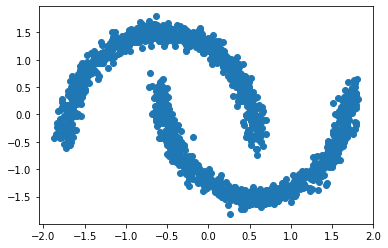

(1500, 2)
(739, 2)
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]] [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]] [[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(1500, 2)


In [ ]:
print(X.shape)
plt.scatter(X[:,0],X[:,1])
plt.show()
Y = np.zeros(X.shape)
print(Y.shape)
print(Output[2].shape)
Y1 = np.ones(Output[1].shape)
Y2 = np.zeros(Output[2].shape)
Y = np.concatenate((Y1,Y2))
print(Y1,Y2,Y)
print(Y.shape)

In [ ]:
class logis_regression:
  # Constructor
  def __init__(self, name='reg'):
    self.name = name  # Create an instance variable

  def logis(self,x,w_old):
    #print(x.T.shape)
    #print(w_old.shape)
    # write code here
    z = np.dot(x.T, w_old)
    op = 1 / (1 + np.exp(-z))
    return op

  def grad_update(self,w_old,lr,y,x):
    # write code here
    N = len(x)
    y_hat = self.logis(x, w_old)
    w_old -= lr * np.dot(x,  y_hat - y) / N 
    return w_old

  def error(self,w_old,y,x):
    predict_1 = y * np.log(self.logis(x,w_old))
    predict_0 = (1 - y) * np.log(1 - self.logis(x,w_old))
    return -sum(predict_1 + predict_0) / len(x)
    

  def Regression_grad_des(self,x,y,lr):
    diff1=1
    diff2=0
    loss = []
    w_old = np.random.rand(x.shape[0],1)
    #print(w_old.shape)
    for i in range(1000):
      # write code here
      diff1 = self.error(w_old,y,x)
      w_old = self.grad_update(w_old,lr,y,x)    
      diff2 = self.error(w_old,y,x)
      loss.append(diff1)
      w_pred = w_old
      err = loss
      dev=np.abs(diff1-diff2)
          
      if dev<=10**(-20):
        break

    return w_pred,err
  
  def predict(self, x,w_pred):
    # Predicting with sigmoid function
    
    # Returning binary result
    return [1 if i > 0.5 else 0 for i in self.logis(x,w_pred)]

In [ ]:
y1=np.zeros((Output[2].shape))
y2=np.ones((Output[1].shape))
y=np.concatenate((y1,y2))
y = y[:,np.newaxis]

In [ ]:
# perform logistic regression

x_aug = np.concatenate((np.ones((1,X.shape[0])),X.T,(X**2).T),axis=0)
print('Shape of Augmented x :',x_aug.shape)
reg = logis_regression()

# By Gradien descent
lr=0.01
w_pred,error_grad=reg.Regression_grad_des(x_aug,y,lr)
print(w_pred)

plt.plot(error_grad)
reg = logis_regression()


In [ ]:
  # estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
connectivity = kneighbors_graph(
X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
n_clusters=params['n_clusters'], linkage='ward',
connectivity=connectivity)
spectral = cluster.SpectralClustering(
n_clusters=params['n_clusters'], eigen_solver='arpack',
affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(
damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
linkage="average", affinity="cityblock",
n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

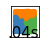

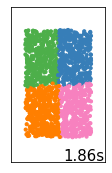

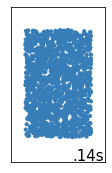

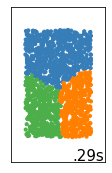

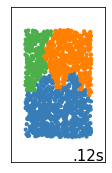

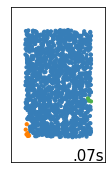

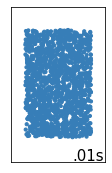

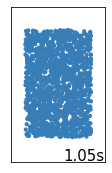

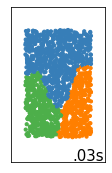

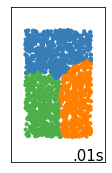

<Figure size 1440x1440 with 0 Axes>

In [ ]:

for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        #plt.figure(figsize=(20,20))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        plt.figure(figsize=(20,20))

plt.show()